# Import Library

In [ ]:
import tensorflow as tf
from tf.keras.applications.vgg16 import VGG16
from tf.keras.applications.resnet50 import ResNet50
from tf import keras
from tf.keras import regularizers
from tf.keras.layers import Dense, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization, Flatten, MaxPooling2D,GlobalAveragePooling2D
from tf.keras.optimizers import Adam, Adamax, RMSprop
from tf.keras.metrics import categorical_crossentropy
from tf.keras.preprocessing.image import ImageDataGenerator
from tf.keras.models import Model, load_model, Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from keras.callbacks import ModelCheckpoint, EarlyStopping

import random
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from pathlib import Path
from matplotlib.pyplot import imshow
from IPython.display import display, HTML
sns.set_style('darkgrid')

# Check GPU Usage

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPU ditemukan: {len(gpus)} GPU tersedia.")
    for gpu in gpus:
        print(f" - {gpu}")
else:
    print("Tidak ada GPU yang terdeteksi.")

# Load Dataset

In [8]:
dataset_dir = '../New_Dataset/skin_cancer_dataset'

train_dir = '../New_Dataset/model_dataset/train'
val_dir = '../New_Dataset/model_dataset/val'

# Splitting Dataset

- Split the Dataset into Traning and Validation

In [ ]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_name)
    
    if os.path.isdir(class_path):
        train_class_dir = os.path.join(train_dir, class_name)
        val_class_dir = os.path.join(val_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(val_class_dir, exist_ok=True)
        
        images = [os.path.join(class_path, img) for img in os.listdir(class_path)]
        
        train_images, val_images = train_test_split(images, test_size=0.2, random_state=42)
        
        for img in train_images:
            shutil.move(img, os.path.join(train_class_dir, os.path.basename(img)))
        
        for img in val_images:
            shutil.move(img, os.path.join(val_class_dir, os.path.basename(img)))

print("Dataset telah dibagi menjadi folder train dan val!")

Dataset telah dibagi menjadi folder train dan val!


- Swow the Number of Training and Validation Data

In [ ]:
train_dir = Path('../New_Dataset/model_dataset/train')
val_dir = Path('../New_Dataset/model_dataset/val')

image_count_train = len(list(train_dir.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(val_dir.glob('*/*.jpg')))
print(image_count_test)

2328
588


In [15]:
def count_images_in_classes(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return class_counts

print('---Training Data---')

class_counts = count_images_in_classes(train_dir)

print("Jumlah gambar per kelas:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

print('\n---Validation Data---')

class_counts_val = count_images_in_classes(val_dir)

print("Jumlah gambar per kelas:")
for class_name, count in class_counts_val.items():
    print(f"{class_name}: {count}")


---Training Data---
Jumlah gambar per kelas:
acne: 202
actinic keratosis: 104
basal cell carcinoma: 313
dermatofibroma: 88
melanoma: 363
nevus: 298
normal: 244
pigmented benign keratosis: 382
seborrheic keratosis: 64
squamous cell carcinoma: 157
vascular lesion: 113

---Validation Data---
Jumlah gambar per kelas:
acne: 51
actinic keratosis: 26
basal cell carcinoma: 79
dermatofibroma: 23
melanoma: 91
nevus: 75
normal: 62
pigmented benign keratosis: 96
seborrheic keratosis: 16
squamous cell carcinoma: 40
vascular lesion: 29


# Preprocessing Data

- Prepare the Dataset

In [6]:
BATCH_SIZE = 32
IMG_HEIGHT = 180
IMG_WIDTH = 180
RND_SEED = 123
random.seed(RND_SEED)

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                               validation_split=0.2,
                                                               subset="training",
                                                               seed=123,
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)

Found 2328 files belonging to 11 classes.
Using 1863 files for training.


In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                             validation_split=0.2,
                                                             subset="validation",
                                                             seed=123,
                                                             image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             batch_size=BATCH_SIZE)

Found 2328 files belonging to 11 classes.
Using 465 files for validation.


In [11]:
test_ds= tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                             validation_split=0.9,
                                                             subset="validation",
                                                             seed=123,
                                                             image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                             batch_size=BATCH_SIZE)

Found 588 files belonging to 11 classes.
Using 529 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['acne', 'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'normal', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


- Dataset Preview

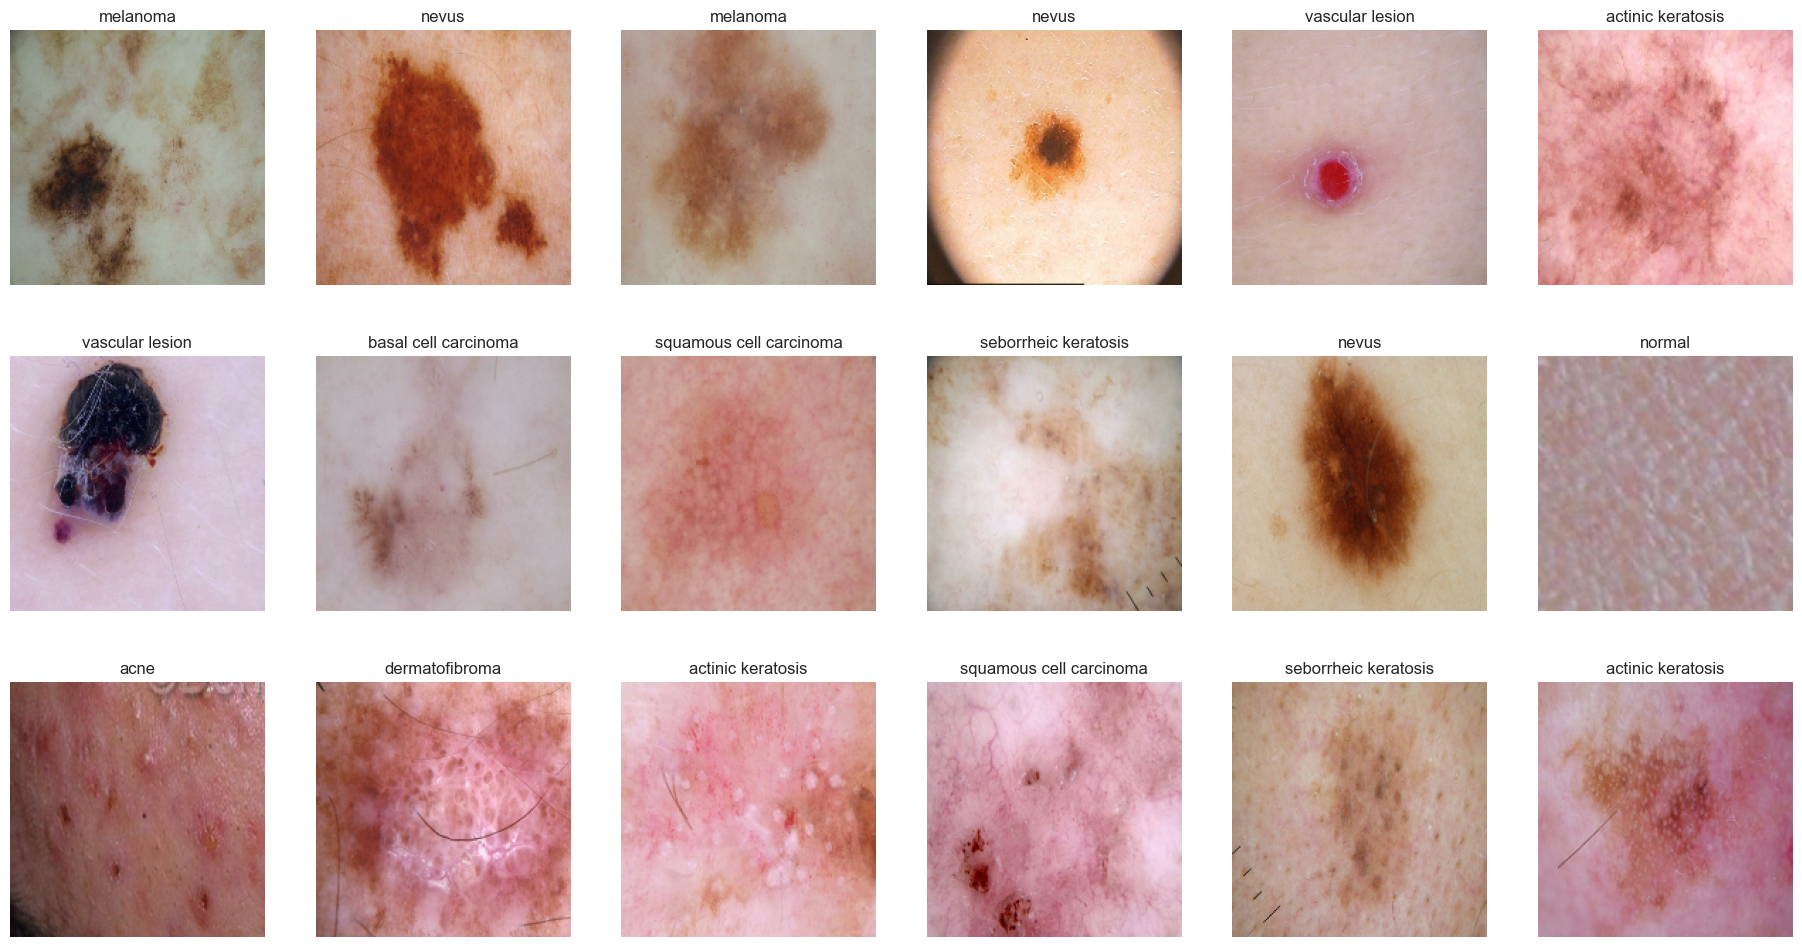

In [ ]:
plt.figure(figsize=(23, 12))
for images, labels in train_ds.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds.take(1):
    print(image_batch.shape)
    print(labels_batch.shape)

(32, 180, 180, 3)
(32,)


In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 1st Model CNN

- Modeling

In [28]:
num_classes = 11
model = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling \
                    (1.0/255,input_shape=(IMG_HEIGHT,IMG_WIDTH,3))])

model.add(Conv2D(32, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(128, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(256, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(512, 3,padding="same",activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024,activation="relu"))
model.add(Dense(units=num_classes, activation= 'softmax'))

In [30]:
opt = Adam(lr=0.001)
model.compile(optimizer= opt,
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [33]:
epochs = 25
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
)

Epoch 1/25


c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


59/59 [==============================] - 14s 109ms/step - loss: 2.3102 - accuracy: 0.1439 - val_loss: 2.2701 - val_accuracy: 0.1656
Epoch 2/25
59/59 [==============================] - 4s 73ms/step - loss: 2.2732 - accuracy: 0.1616 - val_loss: 2.2603 - val_accuracy: 0.1462
Epoch 3/25
59/59 [==============================] - 4s 72ms/step - loss: 2.2682 - accuracy: 0.1702 - val_loss: 2.2284 - val_accuracy: 0.1742
Epoch 4/25
59/59 [==============================] - 4s 72ms/step - loss: 2.2359 - accuracy: 0.1830 - val_loss: 2.0433 - val_accuracy: 0.3312
Epoch 5/25
59/59 [==============================] - 4s 73ms/step - loss: 1.8665 - accuracy: 0.3548 - val_loss: 1.9025 - val_accuracy: 0.2839
Epoch 6/25
59/59 [==============================] - 4s 72ms/step - loss: 1.7154 - accuracy: 0.3940 - val_loss: 1.8914 - val_accuracy: 0.3527
Epoch 7/25
59/59 [==============================] - 4s 74ms/step - loss: 1.5637 - accuracy: 0.4563 - val_loss: 1.7101 - val_accuracy: 0.4409
Epoch 8/25
59/59 [====

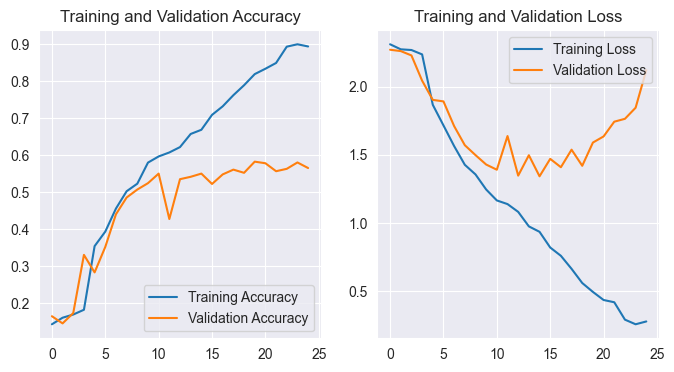

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Data Augmentation

In [37]:
data_augmentation = keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical", 
                                                 input_shape=(IMG_HEIGHT, 
                                                              IMG_WIDTH,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  ]
)

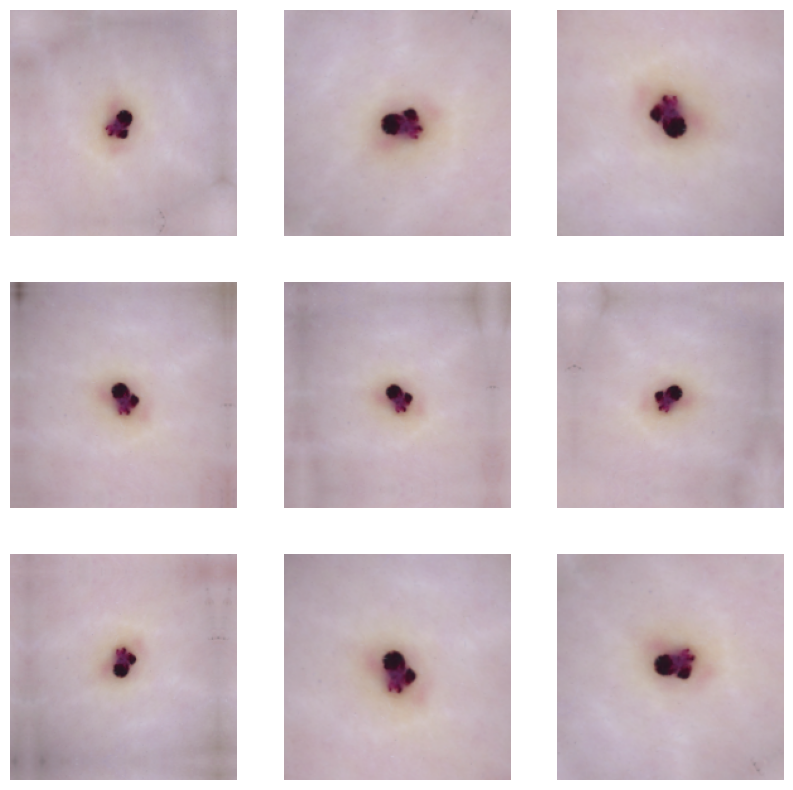

In [38]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# 2nd Model CNN

In [40]:
model2 = Sequential(data_augmentation)
model2.add(tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(IMG_HEIGHT,IMG_WIDTH,3)))

model2.add(Conv2D(32, 3,padding="same",activation='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(64, 3,padding="same",activation='relu'))
model2.add(MaxPooling2D())

model2.add(Conv2D(128, 3,padding="same",activation='relu'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.15))

model2.add(Conv2D(256, 3,padding="same",activation='relu'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.20))

model2.add(Conv2D(512, 3,padding="same",activation='relu'))
model2.add(MaxPooling2D())
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(1024,activation="relu"))
model2.add(Dense(units=num_classes, activation= 'softmax'))

In [41]:
opt = Adam(lr=0.001)
model2.compile(optimizer= opt,
              loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [42]:
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                  

In [43]:
epochs = 25
history2 = model2.fit(train_ds,
                      validation_data=val_ds,
                      epochs=epochs
)

Epoch 1/25


c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


59/59 [==============================] - 14s 198ms/step - loss: 2.3547 - accuracy: 0.1524 - val_loss: 2.2615 - val_accuracy: 0.1785
Epoch 2/25
59/59 [==============================] - 13s 216ms/step - loss: 2.1241 - accuracy: 0.2346 - val_loss: 2.0319 - val_accuracy: 0.2839
Epoch 3/25
59/59 [==============================] - 12s 205ms/step - loss: 1.9227 - accuracy: 0.3333 - val_loss: 1.7666 - val_accuracy: 0.3914
Epoch 4/25
59/59 [==============================] - 12s 195ms/step - loss: 1.7339 - accuracy: 0.3768 - val_loss: 1.6620 - val_accuracy: 0.4237
Epoch 5/25
59/59 [==============================] - 11s 190ms/step - loss: 1.6483 - accuracy: 0.4257 - val_loss: 1.6050 - val_accuracy: 0.4344
Epoch 6/25
59/59 [==============================] - 12s 203ms/step - loss: 1.6029 - accuracy: 0.4514 - val_loss: 1.5843 - val_accuracy: 0.4688
Epoch 7/25
59/59 [==============================] - 13s 225ms/step - loss: 1.4915 - accuracy: 0.4788 - val_loss: 1.4333 - val_accuracy: 0.5097
Epoch 8/25

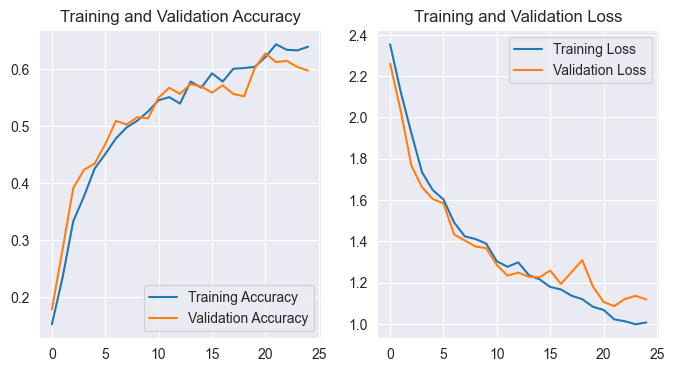

In [46]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

total training image count = 2328 

-------------------------------------
Class name =  acne
count      =  202
proportion =  0.08676975945017182
-------------------------------------
Class name =  actinic keratosis
count      =  104
proportion =  0.044673539518900345
-------------------------------------
Class name =  basal cell carcinoma
count      =  313
proportion =  0.13445017182130584
-------------------------------------
Class name =  dermatofibroma
count      =  88
proportion =  0.037800687285223365
-------------------------------------
Class name =  melanoma
count      =  363
proportion =  0.1559278350515464
-------------------------------------
Class name =  nevus
count      =  298
proportion =  0.12800687285223367
-------------------------------------
Class name =  normal
count      =  244
proportion =  0.10481099656357389
-------------------------------------
Class name =  pigmented benign keratosis
count      =  382
proportion =  0.1640893470790378
-------------------------

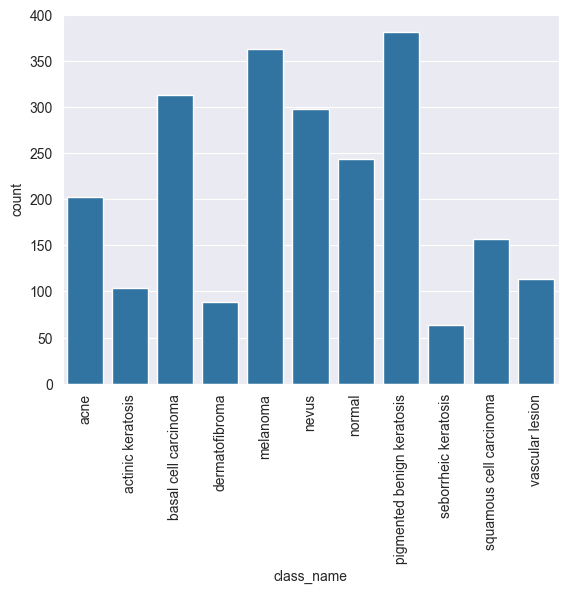

In [47]:
num_classes = len(class_names)
total = 0
all_count = []
class_name = []
for i in range(num_classes):
  count = len(list(train_dir.glob(class_names[i]+'/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(train_dir.glob(class_names[i]+'/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])

temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [49]:
%pip install Augmentor

Note: you may need to restart the kernel to use updated packages.


In [65]:
print(class_names)

['acne', 'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'normal', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


In [ ]:
path_to_training_dataset = '../New_Dataset/model_dataset/train/'

import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i, output_directory='../New_Dataset/model_dataset/train/output/' + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(1000) 

In [2]:
output_dir = Path('../New_Dataset/model_dataset/output_dataset')
image_count_train = len(list(output_dir.glob('*/output/*.jpg')))
print(image_count_train)

11000


total training image count = 11000 

-------------------------------------
Class name =  acne
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  actinic keratosis
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  basal cell carcinoma
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  dermatofibroma
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  melanoma
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  nevus
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  normal
count      =  1000
proportion =  0.09090909090909091
-------------------------------------
Class name =  pigmented benign keratosis
count      =  1000
proportion =  0.09090909090909091
---------------

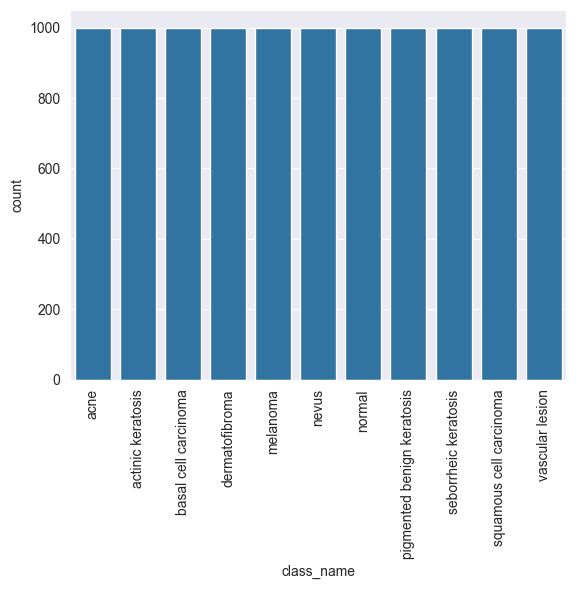

In [27]:
num_classes = 11

total = 0
all_count = []
class_name = []

for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  total += count
print("total training image count = {} \n".format(total))
print("-------------------------------------")
for i in range(num_classes):
  count = len(list(output_dir.glob(class_names[i]+'/output/*.jpg')))
  print("Class name = ",class_names[i])
  print("count      = ",count)
  print("proportion = ",count/total)
  print("-------------------------------------")
  all_count.append(count)
  class_name.append(class_names[i])


temp_df = pd.DataFrame(list(zip(all_count, class_name)), columns = ['count', 'class_name'])
sns.barplot(data=temp_df, y="count", x="class_name")
plt.xticks(rotation=90)
plt.show()

In [28]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(output_dir,
                                                               seed=123,
                                                               validation_split = 0.2,
                                                               subset = 'training',
                                                               image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               batch_size=BATCH_SIZE)

Found 11000 files belonging to 11 classes.
Using 8800 files for training.


In [29]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(output_dir,
                                                            seed=123,
                                                            validation_split = 0.2,
                                                            subset = 'validation',
                                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                                            batch_size=BATCH_SIZE)

Found 11000 files belonging to 11 classes.
Using 2200 files for validation.


In [30]:
print(train_ds.class_names)

['acne', 'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'normal', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# 3rd Model CNN

In [31]:
model3 = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(IMG_HEIGHT,IMG_WIDTH,3))])

model3.add(Conv2D(32, 3,padding="same",activation='relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(64, 3,padding="same",activation='relu'))
model3.add(MaxPooling2D())

model3.add(Conv2D(128, 3,padding="same",activation='relu'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.15))

model3.add(Conv2D(256, 3,padding="same",activation='relu'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.20))

model3.add(Conv2D(512, 3,padding="same",activation='relu'))
model3.add(MaxPooling2D())
model3.add(Dropout(0.25))

model3.add(Flatten())
model3.add(Dense(1024,activation="relu"))
model3.add(Dense(units=num_classes, activation= 'softmax'))

In [32]:
opt = Adam(lr=0.001)
model3.compile(optimizer= opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [33]:
epochs = 25
history3 = model3.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
)

Epoch 1/25


c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


275/275 [==============================] - 24s 78ms/step - loss: 2.2486 - accuracy: 0.1627 - val_loss: 1.9759 - val_accuracy: 0.2614
Epoch 2/25
275/275 [==============================] - 22s 78ms/step - loss: 1.7966 - accuracy: 0.3169 - val_loss: 1.6993 - val_accuracy: 0.3527
Epoch 3/25
275/275 [==============================] - 21s 76ms/step - loss: 1.5584 - accuracy: 0.4174 - val_loss: 1.4661 - val_accuracy: 0.4559
Epoch 4/25
275/275 [==============================] - 21s 76ms/step - loss: 1.3615 - accuracy: 0.4900 - val_loss: 1.2544 - val_accuracy: 0.5336
Epoch 5/25
275/275 [==============================] - 22s 78ms/step - loss: 1.2302 - accuracy: 0.5398 - val_loss: 1.1977 - val_accuracy: 0.5582
Epoch 6/25
275/275 [==============================] - 21s 77ms/step - loss: 1.1073 - accuracy: 0.5909 - val_loss: 1.1167 - val_accuracy: 0.6005
Epoch 7/25
275/275 [==============================] - 22s 79ms/step - loss: 0.9951 - accuracy: 0.6342 - val_loss: 1.0516 - val_accuracy: 0.6341
Epo

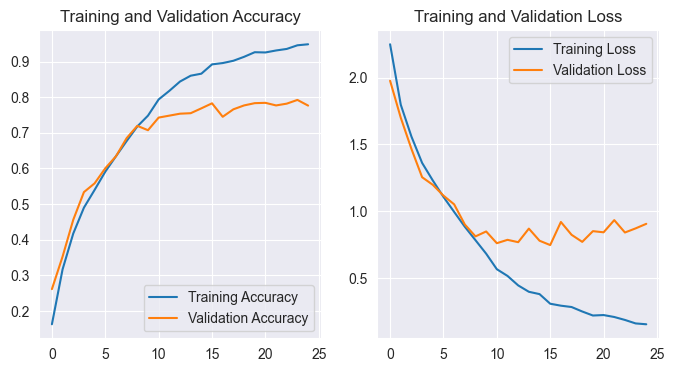

In [34]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
(eval_loss, eval_accuracy) = model3.evaluate(test_ds, batch_size=BATCH_SIZE, \
                                            verbose=1)

17/17 [==============================] - 1s 42ms/step - loss: 2.7643 - accuracy: 0.5255


# 4th Model CNN

In [47]:
model4 = Sequential([tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255,input_shape=(IMG_HEIGHT,IMG_WIDTH,3))])

model4.add(Conv2D(32, 3,padding="same",activation='relu'))
model4.add(MaxPooling2D())

model4.add(Conv2D(64, 3,padding="same",activation='relu'))
model4.add(MaxPooling2D())

model4.add(Conv2D(128, 3,padding="same",activation='relu'))
model4.add(MaxPooling2D())
model4.add(Dropout(0.15))

model4.add(Conv2D(256, 3,padding="same",activation='relu'))
model4.add(MaxPooling2D())
model4.add(Dropout(0.20))

model4.add(Conv2D(512, 3,padding="same",activation='relu'))
model4.add(MaxPooling2D())
model4.add(Dropout(0.25))

model4.add(Flatten())
model4.add(Dense(1024,activation="relu"))
model4.add(Dropout(0.5))
model4.add(Dense(units=num_classes, activation= 'softmax'))

In [48]:
opt = Adam(lr=0.0001)
model4.compile(optimizer= opt,
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

c:\Users\Wahpram\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [49]:
epochs = 25
history4 = model4.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs
)

Epoch 1/25


275/275 [==============================] - 23s 81ms/step - loss: 2.0589 - accuracy: 0.2364 - val_loss: 1.6891 - val_accuracy: 0.4164
Epoch 2/25
275/275 [==============================] - 22s 79ms/step - loss: 1.6040 - accuracy: 0.4205 - val_loss: 1.4940 - val_accuracy: 0.4709
Epoch 3/25
275/275 [==============================] - 23s 82ms/step - loss: 1.4409 - accuracy: 0.4769 - val_loss: 1.3395 - val_accuracy: 0.5014
Epoch 4/25
275/275 [==============================] - 23s 84ms/step - loss: 1.3161 - accuracy: 0.5144 - val_loss: 1.2301 - val_accuracy: 0.5468
Epoch 5/25
275/275 [==============================] - 23s 82ms/step - loss: 1.1930 - accuracy: 0.5589 - val_loss: 1.1284 - val_accuracy: 0.5886
Epoch 6/25
275/275 [==============================] - 22s 81ms/step - loss: 1.0915 - accuracy: 0.5999 - val_loss: 1.0198 - val_accuracy: 0.6209
Epoch 7/25
275/275 [==============================] - 23s 81ms/step - loss: 1.0325 - accuracy: 0.6209 - val_loss: 0.9588 - val_accuracy: 0.6432
Epo

In [43]:
(eval_loss, eval_accuracy) = model4.evaluate(test_ds, batch_size=BATCH_SIZE, \
                                            verbose=1)

17/17 [==============================] - 1s 24ms/step - loss: 1.8415 - accuracy: 0.5860


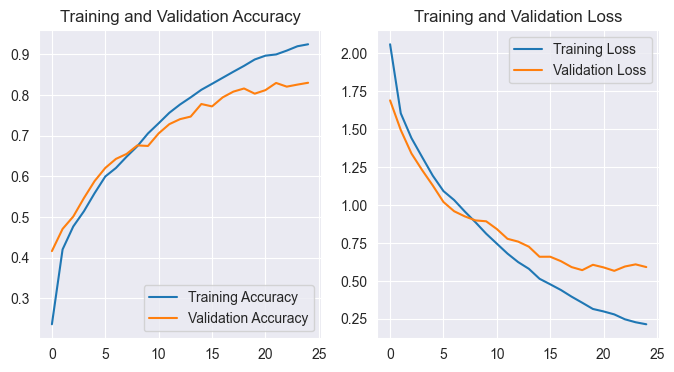

In [50]:
acc = history4.history['accuracy']
val_acc = history4.history['val_accuracy']

loss = history4.history['loss']
val_loss = history4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Prepare Dataset For Categorical Crossentropy 

In [21]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2 
)

train_generator = train_datagen.flow_from_directory(
    output_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    output_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

num_train_data = train_generator.samples
num_val_data = validation_generator.samples

print(f"Jumlah data training: {num_train_data}")
print(f"Jumlah data validasi: {num_val_data}")

Found 8800 images belonging to 11 classes.
Found 2200 images belonging to 11 classes.
Jumlah data training: 8800
Jumlah data validasi: 2200


In [22]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : acne
1 : actinic keratosis
2 : basal cell carcinoma
3 : dermatofibroma
4 : melanoma
5 : nevus
6 : normal
7 : pigmented benign keratosis
8 : seborrheic keratosis
9 : squamous cell carcinoma
10 : vascular lesion


# 1st Model VGG

In [ ]:
def create_vgg16_model(input_shape, num_classes):
    base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
    base_vgg_model.trainable = False

    vgg_model = tf.keras.models.Sequential([
        base_vgg_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.7),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return vgg_model

vgg_model = create_vgg16_model(input_shape=(IMG_WIDTH, IMG_HEIGHT, 3), num_classes=num_classes)
print(num_classes)

vgg_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

vgg_hist = vgg_model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds
)

11
Epoch 1/20
275/275 [==============================] - 44s 145ms/step - loss: 2.2986 - accuracy: 0.2275 - val_loss: 1.7431 - val_accuracy: 0.4041
Epoch 2/20
275/275 [==============================] - 38s 138ms/step - loss: 1.8015 - accuracy: 0.3406 - val_loss: 1.5446 - val_accuracy: 0.4432
Epoch 3/20
275/275 [==============================] - 38s 138ms/step - loss: 1.6272 - accuracy: 0.3964 - val_loss: 1.3939 - val_accuracy: 0.5177
Epoch 4/20
275/275 [==============================] - 38s 138ms/step - loss: 1.5242 - accuracy: 0.4280 - val_loss: 1.3013 - val_accuracy: 0.5500
Epoch 5/20
275/275 [==============================] - 38s 139ms/step - loss: 1.4053 - accuracy: 0.4745 - val_loss: 1.2016 - val_accuracy: 0.5641
Epoch 6/20
275/275 [==============================] - 38s 139ms/step - loss: 1.3134 - accuracy: 0.5161 - val_loss: 1.1033 - val_accuracy: 0.5950
Epoch 7/20
275/275 [==============================] - 39s 140ms/step - loss: 1.2438 - accuracy: 0.5301 - val_loss: 1.0608 - val

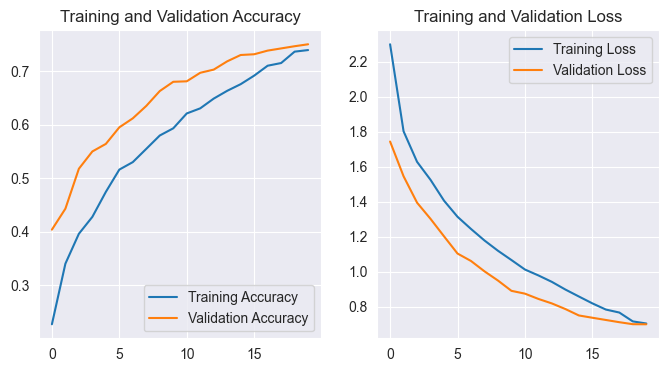

In [20]:
acc = vgg_hist.history['accuracy']
val_acc = vgg_hist.history['val_accuracy']

loss = vgg_hist.history['loss']
val_loss = vgg_hist.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()